In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline
import seaborn as sns

df = pd.read_csv("data/homepage_actions.csv")
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


### 1. Match the following characteristics of this dataset: 
- total number of actions
- number of unique users
- sizes of the control and experiment groups (i.e., the number of unique users in each group)

In [2]:
# total number of actions
len(df.action)

8188

In [3]:
# number of unique users
len(df.id.unique())

6328

In [4]:
# size of control group and experiment group
df[np.logical_not(df.id.duplicated())].group.value_counts()

control       3332
experiment    2996
Name: group, dtype: int64

### 2. How long was the experiment run for? 
Hint: the records in this dataset are ordered by timestamp in increasing order

In [5]:
# Converting string to date time.
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [6]:
# duration of this experiment
df.timestamp.max() - df.timestamp.min()

Timedelta('115 days 16:41:40.789831')

### 3. What action types are recorded in this dataset?
(i.e., What are the unique values in the action column?)

In [7]:
# action types in this experiment
df.action.unique().tolist()

['view', 'click']

### 4. Why would we use click through rate instead of number of clicks to compare the performances of control and experiment pages?

* The control and experiment pages could have different numbers of total visitors;
* More total clicks occur in one version, even if there is a greater percentage of clicks in the other version.

### 5. Define the click through rate (CTR) for this experiment.

The number of unique visitors who click at least once divided by the number of unique visitors who view the page

### 6. What are the null and alternative hypotheses?
Use $CTR_{old}$ and $CTR_{new}$ in your hypotheses.

$$H_0 : CTR_{new} - CTR_{old} \leq 0 \\
  H_1 : CTR_{new} - CTR_{old} > 0$$

## A/B Testing

Let's calculate the Click through rate of this experiment.

In [8]:
# Copying df.
df_control = df.copy()
df_experiment = df.copy()

### Control Group

In [9]:
# Subsetting only control group
df_control = df.query("group == 'control'")

# First 5 rows of subsetted data frame.
df_control.head()

,timestamp,id,group,action
3,2016-09-24 19:59:02.646620,671993,control,view
9,2016-09-24 21:00:12.278374,560027,control,view
23,2016-09-25 00:25:14.141290,281985,control,view
24,2016-09-25 01:14:48.603202,407864,control,view
25,2016-09-25 02:16:11.046654,342984,control,view


#### Control Group CTR

In [10]:
# Number of clicks from a unique id.
click_unique_id_ctrl = df_control.query('action == "click"').id.nunique()

# Number of views from a unique id.
views_unique_id_ctrl = df_control.query('action == "view"').id.nunique()

# Number of Clicks through Rate.
control_ctr = click_unique_id_ctrl / views_unique_id_ctrl

# Printing the ctr.
control_ctr

0.2797118847539016

### Experiment Group

In [11]:
# Subsetting only experiment group
df_experiment = df.query("group == 'experiment'")

# First 5 rows of subsetted data frame.
df_experiment.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
4,2016-09-24 20:26:14.466886,536734,experiment,view
5,2016-09-24 20:32:25.712659,681598,experiment,view


#### Experiment Group CTR

In [12]:
# Number of clicks from a unique id.
click_unique_id_exp = df_experiment.query('action == "click"').id.nunique()

# Number of views from a unique id.
views_unique_id_exp = df_experiment.query('action == "view"').id.nunique()

# Number of Clicks through Rate.
experiment_ctr = click_unique_id_exp / views_unique_id_exp

# Printing the ctr.
experiment_ctr

0.3097463284379172

### CTR's Difference

Founded on the Hypotheses:

$$H_0 : CTR_{new} - CTR_{old} \leq 0 \\
  H_1 : CTR_{new} - CTR_{old} > 0$$

O need to calculate the difference between `experiment_ctr` and `control_ctr`.

In [13]:
# Difference
diff = experiment_ctr - control_ctr

# Pritting the diff
diff

0.030034443684015644

This is the observed difference between the Control and Experiment groups. 

Let's make a bootstrap using the `df` data frame as population.

## Bootstrapping

This bootstrapping will be performed using:

* 10,000 samples;
* Sample size equal to the length of the `df` dataframe.

In [14]:
# Difference of ctr from each sample.
diff_ctr = []

# Size of each sample.
size = df.shape[0]

# Loop to create the 10,000 samples.
for _ in range(10000):
    # Creating the sample.
    df_sample = df.sample(size, replace=True)

    # Subsetting only control group
    df_control = df_sample.query("group == 'control'")
    # Number of clicks from a unique id.
    click_unique_id_ctrl = df_control.query('action == "click"').id.nunique()
    # Number of views from a unique id.
    views_unique_id_ctrl = df_control.query('action == "view"').id.nunique()
    # Number of Clicks through Rate.
    control_ctr = click_unique_id_ctrl / views_unique_id_ctrl

    # Subsetting only experiment group
    df_experiment = df_sample.query("group == 'experiment'")
    # Number of clicks from a unique id.
    click_unique_id_exp = df_experiment.query('action == "click"').id.nunique()
    # Number of views from a unique id.
    views_unique_id_exp = df_experiment.query('action == "view"').id.nunique()
    # Number of Clicks through Rate.
    experiment_ctr = click_unique_id_exp / views_unique_id_exp

    # Difference
    sample_diff = experiment_ctr - control_ctr

    # Appending the sample diff in diff_ctr
    diff_ctr.append(sample_diff)

### Plotting histograms

Let visualize if the `diff_ctr` has a normal distribution.

<Figure size 1008x432 with 0 Axes>

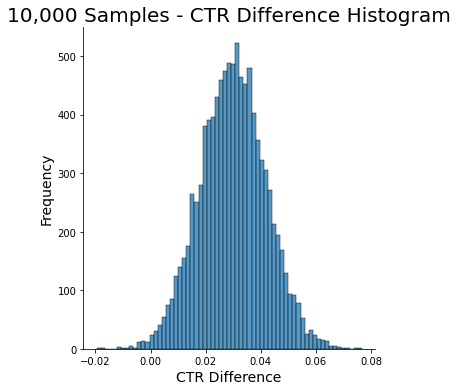

(0.006555574763766741, 0.05340487985415278)

In [15]:
# Plotting a histogram.
plt.figure(figsize=[14, 6])
sns.displot(diff_ctr)
plt.title("10,000 Samples - CTR Difference Histogram", fontsize=20)
plt.xlabel("CTR Difference", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()
np.percentile(diff_ctr, 2.5), np.percentile(diff_ctr, 97.5)

Now, let's plot a normal distribution expected from a population and based on the standard deviation from the `df` data frame (our population).

In [16]:
# Standard Deviation Calculation
pop_std = np.std(diff_ctr)

# Generating a Normal Distribution with center in zero and standard deviation equal to the population.
population = np.random.normal(0, pop_std, size=10000)

<Figure size 1008x432 with 0 Axes>

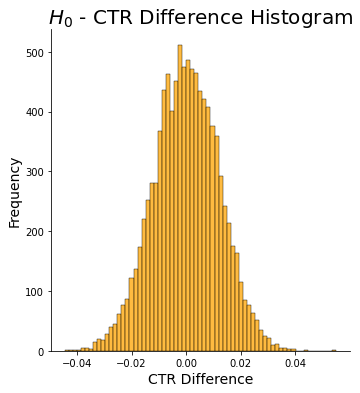

In [17]:
# Plotting a histogram.
plt.figure(figsize=[14, 6])
sns.displot(population, color="orange")
plt.title("$H_0$ - CTR Difference Histogram", fontsize=20)
plt.xlabel("CTR Difference", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

Let's overlap these two histogram to visualize it.

<Figure size 1008x432 with 0 Axes>

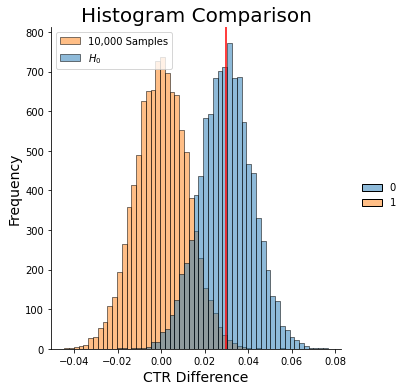

In [18]:
# Plotting a histogram.
plt.figure(figsize=[14, 6])
sns.displot([diff_ctr, population], color=["r", "b"])
plt.title("Histogram Comparison", fontsize=20)
plt.xlabel("CTR Difference", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(["10,000 Samples", "$H_0$"])
plt.axvline(diff, color="red")
plt.show()

### P-value

Founded on the entire population (excepting the duplicated user id, etc.), I have calculated the `diff`.

$$ \text{diff = experiment_ctr - control_ctr =} 0.030034443684015644$$

The `diff` could be interpreted as a threshold which I will use as delimiter, to do it I will calculate the proportion of $H_0$ (orange graph) that has a difference between CTR's higher than `diff`.

For this reason, I will calculate the average of a list of `bool`, which will return the proportion I want.

In [19]:
# Calculating the proportion of orange graph which has diff greater than diff.
p_value = (population > diff).mean()

# Printting the p_value
p_value

0.0056

Based on the `p_value` of 0.5% we reject the $H_0$.

$$ p\_value \leq \alpha$$

>**Conclusion:** Audacity should launch the new version of the home page. 